## Customer churn.

###### The goal of the project is to predict the customer churn.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

In [2]:
df=pd.read_csv('/datasets/Churn.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Check the data for duplicate rows.

In [3]:
df[df.duplicated(keep=False)]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


We can see that there are 909 missing values in "Tenure" column. In my opinion NaNs in this column mean that customer doesn't have deposit at all.

Let's fill missing values with "-1" value. Then convert "Tenure" to numeric type.

In [4]:
df['Tenure'].fillna('-1', inplace=True)

In [5]:
df['Tenure']=pd.to_numeric(df['Tenure'])

There is no relationship between RowNumber, CustomerId, customer Surname and his decision to stay or leave. So we"ll drop these columns.  

In [6]:
data=df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


* ### Class frequency

Let's check how often the target feature contains the class "1" or "0".

In [7]:
class_frequency = data['Exited'].value_counts(normalize=True)
class_frequency

0    0.7963
1    0.2037
Name: Exited, dtype: float64

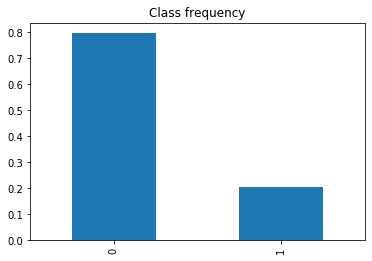

In [8]:
class_frequency.plot(kind='bar');
plt.title('Class frequency');

We have imbalanced dataset: class '0' : 80% and class '1' : 20%. 

Let's train some models without taking into account the imbalance. Than, use several approaches to fix class imbalance and check if it improves the quality of the model.  

Since we are dealing with categorical target (Exited: 1, 0) this is classification task. 

First, transform categorical features (Geography and Gender) into numerical features using One-Hot Encoding (OHE). We'll call pd.get_dummies() for all data and set True the drop_first argument to avoid the dummy trap. 

In [9]:
data_ohe = pd.get_dummies(data, drop_first=True)
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

Now split our data into three parts: train(60%), valid(20%) and test(20%) using train_test_split() function twice. 

In [10]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, shuffle=False)

Scale the numeric data using StandardScaler() from sklearn.preprocessing module.  

In [11]:
numeric = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Let's look at Logistic Regression and Random Forest for imbalanced data and check metrics.

* #### Logistic Regression

We'll concern f1 score that is the harmonic mean of recall and precision, and auc_roc that tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. We also want f1 to be close to 1.

In [12]:
model_regression = LogisticRegression(random_state=12345, solver='liblinear')
model_regression.fit(features_train, target_train)

train_accuracy = model_regression.score(features_train, target_train)
valid_accuracy = model_regression.score(features_valid, target_valid)

print("Training set:", train_accuracy)
print("Validation set:", valid_accuracy)

Training set: 0.8188333333333333
Validation set: 0.7935


In [13]:
predicted_valid = model_regression.predict(features_valid)

p_r_f_s=precision_recall_fscore_support(target_valid, predicted_valid)
reg = pd.DataFrame(p_r_f_s).T
reg.columns=['precision','recall','f1-score','support']
reg

,precision,recall,f1-score,support
0,0.814534,0.954863,0.879134,1573.0
1,0.544872,0.199063,0.291595,427.0


Unlike other metrics, auc_roc takes class "1" probabilities instead of predictions. The class probability can be calculated with the predict_proba() function.

In [14]:
probabilities_valid = model_regression.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

auc_roc

0.7564402810304449

* #### Random Forest

Let's check another model - Random Forest. We'll iterate over n_estimators values from 10 to 50 and find the best value of accuracy.

In [15]:
for estim in range(10,51,10):
        model_forest = RandomForestClassifier(n_estimators=estim, max_depth=10, random_state=12345)
        model_forest.fit(features_train, target_train)
        
        train_accuracy = model_forest.score(features_train, target_train)
        valid_accuracy = model_forest.score(features_valid, target_valid)

        print("n_estimators =", estim)
        print("Training set:", train_accuracy)
        print("Validation set:", valid_accuracy)

n_estimators = 10
Training set: 0.901
Validation set: 0.8535
n_estimators = 20
Training set: 0.9051666666666667
Validation set: 0.8475
n_estimators = 30
Training set: 0.904
Validation set: 0.849
n_estimators = 40
Training set: 0.9051666666666667
Validation set: 0.8485
n_estimators = 50
Training set: 0.9063333333333333
Validation set: 0.852


The best value we achieve with n_estimators = 10 that gives us training set accuracy: 90% and validation set: 85%  

In [16]:
model_forest = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=12345)
model_forest.fit(features_train, target_train)
predicted_valid = model_forest.predict(features_valid)

In [17]:
p_r_f_s=precision_recall_fscore_support(target_valid, predicted_valid)
rf = pd.DataFrame(p_r_f_s).T
rf.columns=['precision','recall','f1-score','support']
rf

,precision,recall,f1-score,support
0,0.861991,0.968849,0.912302,1573.0
1,0.788793,0.428571,0.555387,427.0


In [18]:
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

auc_roc

0.8530128589741109

Concerning two models LogisticRegression and RandomForest for imbalanced dataset, we can say that RandomForest gives us better f1 score for class '1' (RandomForest better predicts class '1' then LogisticRegression). Also roc_auc_score of RandomForest is higher then roc_auc of LogisticRegression. Thus, RandomForest model is better then LogisticRegression.   

Let's use some approaches to fix class imbalance and check if it will improve f1 and roc_auc scores.

We'll use three methods:
* Class weight adjustment
* Upsampling
* Downsampling 

#### Class weight adjustment

Let's set parameter class_weight='balanced' for LogisticRegresion and RandomForest 

In [19]:
model = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

report=classification_report(target_valid, predicted_valid, output_dict=True)
report_b = pd.DataFrame(report).T
report_b

,precision,recall,f1-score,support
0,0.892456,0.706929,0.788932,1573.0000
1,0.388594,0.686183,0.496190,427.0000
accuracy,0.702500,0.702500,0.702500,0.7025
macro avg,0.640525,0.696556,0.642561,2000.0000
weighted avg,0.784881,0.702500,0.726432,2000.0000


In [20]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

auc_roc

0.7620159274406666

In [21]:
model_forest = RandomForestClassifier(n_estimators=10, max_depth=10, class_weight='balanced', random_state=12345)
model_forest.fit(features_train, target_train)
predicted_valid = model_forest.predict(features_valid)

report=classification_report(target_valid, predicted_valid, output_dict=True)
report_b = pd.DataFrame(report).T
report_b

,precision,recall,f1-score,support
0,0.900065,0.881755,0.890816,1573.00
1,0.594771,0.639344,0.616253,427.00
accuracy,0.830000,0.830000,0.830000,0.83
macro avg,0.747418,0.760549,0.753534,2000.00
weighted avg,0.834885,0.830000,0.832197,2000.00


In [22]:
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

auc_roc

0.8447119199727248

For LogisticRegression class weight adjustment method improved both metrics f1 for class '1' (from 0.29 to 0.49) and roc_auc_score (from 0.75 to 0.76). For RandomForest we can see incresing of f1 score (from 0.55 to 0.61) and slightly decreasing of roc_auc (from 0.85 to 0.84).

Again, RandomForest model perfomes better then LogisticRegression. 

#### Upsampling

Upsampling is the process of randomly duplicating observations from the minority class.

We'll import the resample module from sklearn.utils.

In [23]:
target_train.value_counts()

0    4804
1    1196
Name: Exited, dtype: int64

In [24]:
# Separate majority and minority classes
features_train_zeros = features_train[target_train == 0]
features_train_ones = features_train[target_train == 1]
target_train_zeros = target_train[target_train == 0]
target_train_ones = target_train[target_train == 1]
 
# Upsample minority class
features_minority_upsampled = resample(features_train_ones, 
                                 replace=True,     # sample with replacement
                                 n_samples=4804,    # to match majority class
                                 random_state=123) # reproducible results

target_minority_upsampled = resample(target_train_ones, 
                                 replace=True,     
                                 n_samples=4804,    
                                 random_state=123)

# Combine majority class with upsampled minority class
features_upsampled = pd.concat([features_minority_upsampled,features_train_zeros])
target_upsampled=pd.concat([target_minority_upsampled,target_train_zeros])

In [25]:
target_upsampled.value_counts()

1    4804
0    4804
Name: Exited, dtype: int64

Let's train LogisticRegression and RandomForest on the balanced dataset.

In [26]:
model=LogisticRegression(solver='liblinear')
model.fit(features_upsampled,target_upsampled)
predicted_valid=model.predict(features_valid)

report=classification_report(target_valid, predicted_valid, output_dict=True)
report_up = pd.DataFrame(report).T
report_up

,precision,recall,f1-score,support
0,0.893566,0.715194,0.794492,1573.000
1,0.395412,0.686183,0.501712,427.000
accuracy,0.709000,0.709000,0.709000,0.709
macro avg,0.644489,0.700688,0.648102,2000.000
weighted avg,0.787210,0.709000,0.731983,2000.000


In [27]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

auc_roc

0.7637786952242988

In [28]:
model_forest = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=12345)
model_forest.fit(features_upsampled,target_upsampled)
predicted_valid=model_forest.predict(features_valid)

report=classification_report(target_valid, predicted_valid, output_dict=True)
report_up = pd.DataFrame(report).T
report_up

,precision,recall,f1-score,support
0,0.908177,0.861411,0.884176,1573.0000
1,0.570866,0.679157,0.620321,427.0000
accuracy,0.822500,0.822500,0.822500,0.8225
macro avg,0.739522,0.770284,0.752249,2000.0000
weighted avg,0.836161,0.822500,0.827843,2000.0000


In [29]:
model_forest = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=12345)
model_forest.fit(features_upsampled,target_upsampled)

probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

auc_roc

0.8540572691094301

Upsampling compared to Class weight adjustment slightly improved f1 and roc_auc for both models.

LogisticRegression f1: from 0.49 to 0.50; roc_auc: the same 0.76

RandomForest f1: from 0.61 to 0.62; roc_auc: from 0.84 to 0.85.

Still RandomForest leads.

#### Downsampling

Downsampling involves randomly removing observations from the majority class. The process is similar to that of upsampling, but we'll resample the majority class without replacement (replace=False).

In [30]:
# Separate majority and minority classes
features_train_zeros = features_train[target_train == 0]
features_train_ones = features_train[target_train == 1]
target_train_zeros = target_train[target_train == 0]
target_train_ones = target_train[target_train == 1]
 
# Downsample majority class
features_majority_downsampled = resample(features_train_zeros, 
                                 replace=False,      # sample without replacement
                                 n_samples=1196,     # to match minority class
                                 random_state=123) # reproducible results

target_majority_downsampled = resample(target_train_zeros, 
                                 replace=False,      
                                 n_samples=1196,     
                                 random_state=123) 

# Combine minority class with downsampled majority class
features_downsampled = pd.concat([features_majority_downsampled,features_train_ones])
target_downsampled=pd.concat([target_majority_downsampled,target_train_ones])


In [31]:
target_downsampled.value_counts()

1    1196
0    1196
Name: Exited, dtype: int64

In [32]:
model=LogisticRegression(solver='liblinear')
model.fit(features_downsampled,target_downsampled)
predicted_valid=model.predict(features_valid)

report=classification_report(target_valid, predicted_valid, output_dict=True)
report_down = pd.DataFrame(report).T
report_down

,precision,recall,f1-score,support
0,0.891914,0.708201,0.789511,1573.000
1,0.388815,0.683841,0.495756,427.000
accuracy,0.703000,0.703000,0.703000,0.703
macro avg,0.640364,0.696021,0.642633,2000.000
weighted avg,0.784502,0.703000,0.726794,2000.000


In [33]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

auc_roc

0.7609543958277193

In [34]:
model_forest = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=12345)
model_forest.fit(features_downsampled,target_downsampled)
predicted_valid=model_forest.predict(features_valid)

report=classification_report(target_valid, predicted_valid, output_dict=True)
report_down = pd.DataFrame(report).T
report_down

,precision,recall,f1-score,support
0,0.917983,0.775588,0.840799,1573.000
1,0.473920,0.744731,0.579235,427.000
accuracy,0.769000,0.769000,0.769000,0.769
macro avg,0.695951,0.760159,0.710017,2000.000
weighted avg,0.823176,0.769000,0.784955,2000.000


In [35]:
model_forest = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=12345)
model_forest.fit(features_downsampled,target_downsampled)

probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

auc_roc

0.8396752279017554

Downsampling compared to Upsampling didn't improved f1 and roc_auc for both models.

And still RandomForest is better then LogisticRegression.

Now we will use our test set that was untouched till now and check on it RandomForest quality. We want f1 score to be at least 0.59.  

In [36]:
features_test[numeric] = scaler.transform(features_test[numeric])

In [37]:
model_forest = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=12345)
model_forest.fit(features_upsampled,target_upsampled)
predicted_test=model_forest.predict(features_test)

report=classification_report(target_test, predicted_test, output_dict=True)
df_fin = pd.DataFrame(report).T
df_fin

,precision,recall,f1-score,support
0,0.901062,0.855612,0.877749,1586.000
1,0.536437,0.640097,0.583700,414.000
accuracy,0.811000,0.811000,0.811000,0.811
macro avg,0.718750,0.747854,0.730725,2000.000
weighted avg,0.825585,0.811000,0.816881,2000.000


In [38]:
probabilities_valid = model_forest.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_valid)

auc_roc

0.8361599990252876

In [39]:
model_forest = RandomForestClassifier(n_estimators=10, max_depth=10, class_weight='balanced', random_state=12345)
model_forest.fit(features_train, target_train)
predicted_test = model_forest.predict(features_test)

report=classification_report(target_test, predicted_test, output_dict=True)
df_fin = pd.DataFrame(report).T
df_fin

,precision,recall,f1-score,support
0,0.895674,0.887768,0.891704,1586.000
1,0.584112,0.603865,0.593824,414.000
accuracy,0.829000,0.829000,0.829000,0.829
macro avg,0.739893,0.745816,0.742764,2000.000
weighted avg,0.831181,0.829000,0.830043,2000.000


In [40]:
probabilities_valid = model_forest.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_valid)

auc_roc

0.8232008942985423

##### Training RandomForest on test set we found that fixing class imbalance using Class weight adjustment gave us desired f1 score for class '1' 0.59 and also good value of roc_auc_score - 0.82.

##### So, RandomForest model with parameters: n_estimators=10, max_depth=10, class_weight='balanced' gives us the best result.  